In [3]:
import sys
sys.path.insert(0, '..')

from database.dataset import INBreast_Dataset
from general_utils.plots import simple_im_show, plot_blobs2, plot_blobs
from mc_candidate_proposal.morphology_mc import MorphologyDetection
from tqdm import tqdm

from general_utils.utils import get_center_bboxes
from metrics.metrics import get_tp_fp_fn
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=1.0, #max 315 pixels area
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    partitions = ['train'],
    n_jobs=-1,
    lesion_types=['calcification']
)

## Single image test

This section is used for testing individual detection steps. Infore it if need general results

{'img_id': 24065914, 'TP': 5, 'FP': 4216, 'FN': 3}


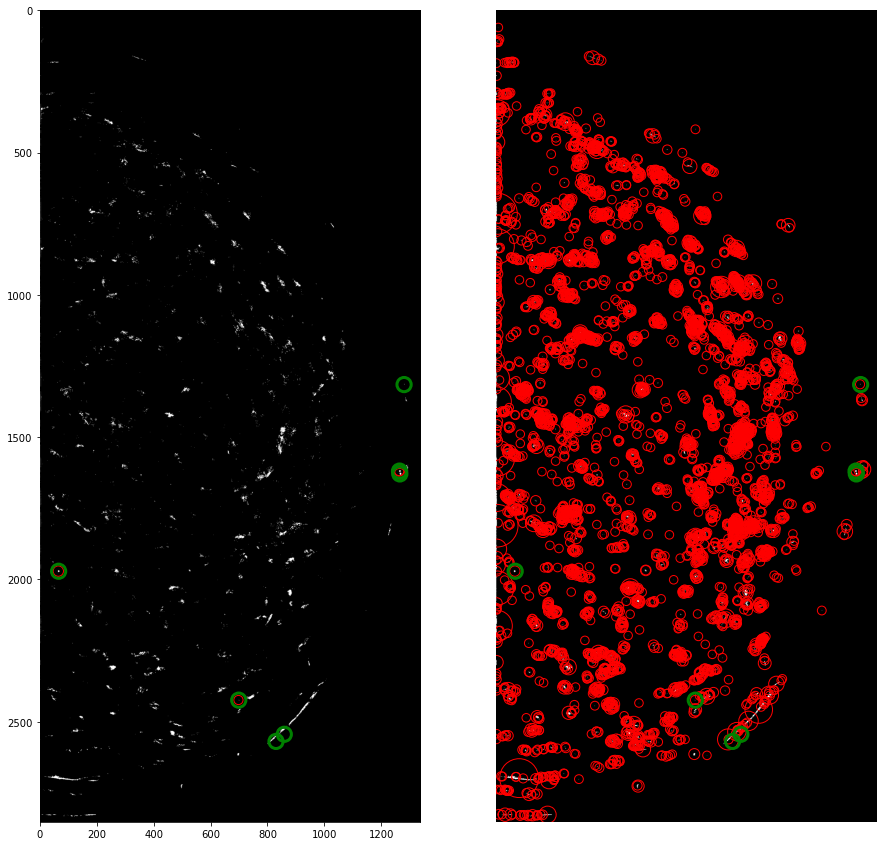

In [50]:
rbd_path = '/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img'

md = MorphologyDetection(rbd_path, threshold=0.97, alternative=False, store_intermediate=True)

idx = 141
case = db[idx]
image = case['img']
image_id = db.df.iloc[idx].img_id
radiouses = case['radiuses']
true_bboxes = db[idx]['lesion_bboxes']
selected_cc_mask, candidate_blobs = md.detect(image, image_id)

tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, candidate_blobs, 7, 0.1)
img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn)}
print(img_res)

radiouses = np.expand_dims(radiouses.astype(int), 1)
gt_centers = get_center_bboxes(true_bboxes)
gt_circles = np.concatenate([gt_centers, radiouses], axis=1)

f, ax = plt.subplots(1, 2, figsize=(15,25))
plot_blobs2(selected_cc_mask>0, tp, gt_circles, ax=ax[0])
plot_blobs2(selected_cc_mask>0, candidate_blobs, gt_circles, ax=ax[1])
plt.axis('off')
plt.show()

{'img_id': 24065914, 'TP': 4, 'FP': 3232, 'FN': 4}


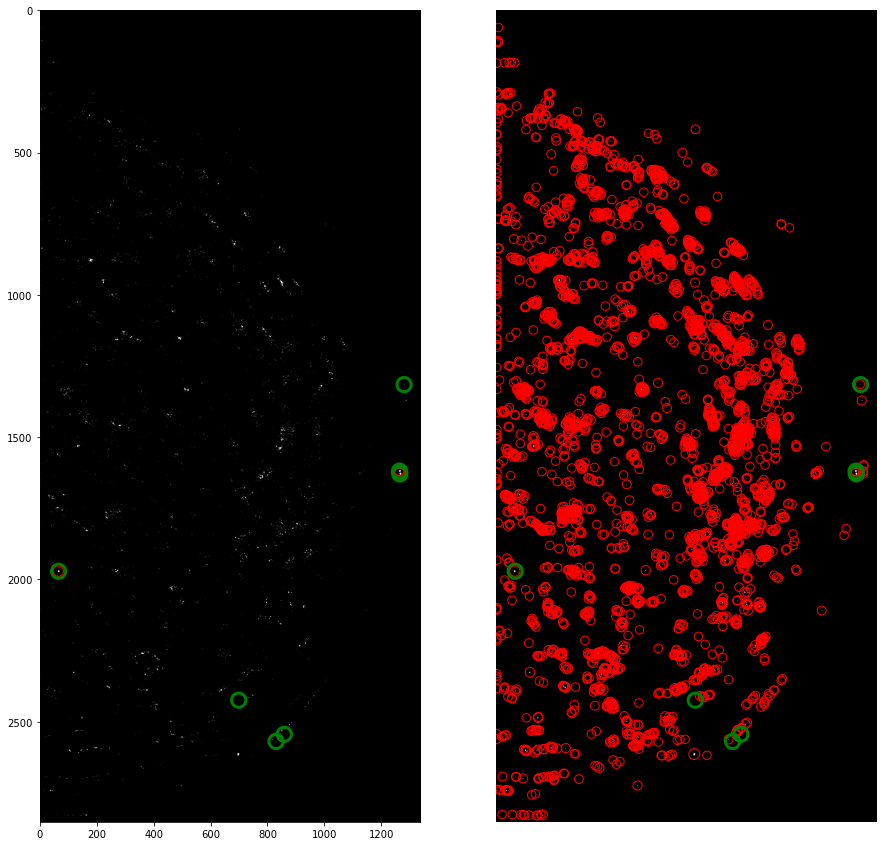

In [51]:
rbd_path = '/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img'

md = MorphologyDetection(rbd_path, threshold=0.97, alternative=True, store_intermediate=True)

idx = 141
case = db[idx]
image = case['img']
image_id = db.df.iloc[idx].img_id
radiouses = case['radiuses']
true_bboxes = db[idx]['lesion_bboxes']
selected_cc_mask, candidate_blobs = md.detect(image, image_id)

tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, candidate_blobs, 7, 0.1)
img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn)}
print(img_res)

radiouses = np.expand_dims(radiouses.astype(int), 1)
gt_centers = get_center_bboxes(true_bboxes)
gt_circles = np.concatenate([gt_centers, radiouses], axis=1)

f, ax = plt.subplots(1, 2, figsize=(15,25))
plot_blobs2(selected_cc_mask>0, tp, gt_circles, ax=ax[0])
plot_blobs2(selected_cc_mask>0, candidate_blobs, gt_circles, ax=ax[1])
plt.axis('off')
plt.show()

## All dataset test

In [5]:
import cv2
import numpy as np
from skimage.measure import label
from pathlib import Path


class MorphologyDetection:
    def __init__(
        self, rbd_img_path: str, threshold: float, alternative: bool = False,
        store_intermediate: bool = True
    ):
        self.use_alternative = alternative
        self.rbd_img_path = Path(rbd_img_path)
        self.threshold = threshold
        self.store_intermediate = store_intermediate
        if self.use_alternative:
            self.dilation_k_size = 14
        else:
            self.dilation_k_size = 20

    def detect(self, image: np.ndarray, image_id: int, ):

        self.image = image

        # load or create reconstructed by dialation image
        rbd_image = None
        if (self.rbd_img_path/f'{image_id}.tiff').exists():
            rbd_image = cv2.imread(
                str(self.rbd_img_path/f'{image_id}.tiff'),  cv2.IMREAD_ANYDEPTH)

        if rbd_image is None:
            rbd_image = self.reconstruction_by_dialation(
                image, circle_size=self.dilation_k_size)
            if self.store_intermediate:
                cv2.imwrite(str(self.rbd_img_path/f'{image_id}.tiff'), rbd_image)

        # erode breast boundary to avoid FP there
        rbd_image_no_bbound = self.breast_boundary_erosion(rbd_image)

        # intensity thresholding
        trheshold = np.quantile(
            rbd_image_no_bbound[rbd_image_no_bbound != 0].ravel(), q=self.threshold)
        thr1_rbd = rbd_image_no_bbound.copy()
        thr1_rbd[thr1_rbd <= trheshold] = 0

        if self.use_alternative:
            quant = 0.8
            trheshold = np.quantile(rbd_image_no_bbound[thr1_rbd > 0].ravel(), q=quant)
            thr_rbd = rbd_image_no_bbound.copy()
            thr_rbd[thr_rbd <= trheshold] = 0
        else:
            thr_rbd = thr1_rbd

        # connected components extraction and filtering
        markers = self.connected_components_extraction(thr1_rbd)
        cc_mask = self.connected_components_filtering(markers)
        return cc_mask

    def reconstruction_by_dialation(
        self, mask: np.ndarray, rect_size: int = 3, circle_size: int = 20
    ):
        """Reconstructs image using grayscale dialation
        Args:
            mask (np.ndarray): Image arre of type float or np.uint8
            rect_size (int, optional):
                Size of the SE used for geodesic reconstruction. Defaults to 3.
            circle_size (int, optional):
                Size of the SE used for creating a marker image. Defaults to 20.
        """
        rect_SE = cv2.getStructuringElement(
            cv2.MORPH_RECT, (rect_size, rect_size))
        circle_SE = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (circle_size, circle_size))

        marker_cur = cv2.morphologyEx(mask, cv2.MORPH_OPEN, circle_SE)
        marker_prev = np.zeros_like(marker_cur)
        while (not (marker_prev == marker_cur).all()):
            marker_prev = marker_cur.copy()
            marker_cur = cv2.min(cv2.dilate(marker_prev, rect_SE), mask)
        return mask - marker_cur

    def breast_boundary_erosion(self, rbd_image: np.ndarray):
        """Use breast mask and remove its contour from the detection image"""
        erosion_size = 5
        erosion_iter = 10

        breast_mask = (self.image != 0).astype(np.uint8)
        structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT,
                                                        (erosion_size, erosion_size))
        breast_boundary_mask = cv2.erode(breast_mask, structuring_element,
                                         iterations=erosion_iter)
        rbd_image_no_bbound = rbd_image.copy()
        rbd_image_no_bbound[breast_boundary_mask == 0] = 0
        return rbd_image_no_bbound

    def connected_components_extraction(self, thr1_rbd: np.ndarray):
        """Finds connected components"""
        # binarize and perform connected components labeling
        thr1_rbd_bin = self.to_uint8(255*(thr1_rbd > 0))
        markers, _ = label(thr1_rbd_bin, background=0,
                           return_num=True, connectivity=1)
        return markers

    def connected_components_filtering(self, markers: np.ndarray):
        """Filter connected components"""
        # connected components filtering
        selected_cc = []
        candidate_blobs = []
        out = np.zeros_like(markers, dtype='uint16')
        if self.use_alternative:
            contours, _ = cv2.findContours(np.where(markers > 0, 255, 0).astype('uint8'),
                                           cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i, obj in enumerate(contours):
                A = cv2.contourArea(obj)
                A = 1 if A == 0 else A
                if A > 14 * 14:
                    continue
                p = cv2.arcLength(obj, True)
                p = 1 if p == 0 else p
                c = (4 * np.pi * A) / (p * p)
                if c > 0.6:
                    selected_cc.append(obj)
                    center, r = cv2.minEnclosingCircle(obj)
                    candidate_blobs.append((center[0], center[1], r))
                    # out = cv2.drawContours(out, contours, i, i+1, -1)
            out = cv2.drawContours(out, selected_cc, -1, 255, -1)
            # markers[~candidates_mask] = 0
            return out, candidate_blobs
        else:
            contours, _ = cv2.findContours(
                np.where(markers > 0, 255, 0).astype('uint8'),
                cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            for i, obj in enumerate(contours):
                A = cv2.contourArea(obj)
                if 14*14 > A >= 0:
                    selected_cc.append(obj)
                    center, r = cv2.minEnclosingCircle(obj)
                    candidate_blobs.append((center[0], center[1], r))
                    # out = cv2.drawContours(out, contours, i, i+1, -1)
            out = cv2.drawContours(out, selected_cc, -1, 255, -1)
            # markers[out == 0] = 0
            return out, candidate_blobs

    @staticmethod
    def min_max_norm(img):
        return (img - img.min())/(img.max() - img.min())

    def to_uint8(self, img):
        return (255*self.min_max_norm(img)).astype(np.uint8)

In [92]:
import time
res_alt_ = []
for idx in tqdm(range(len(db))):
    rbd_path = '/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img'
    md = MorphologyDetection(rbd_path, threshold=0.97, alternative=True, store_intermediate=True)
    case = db[idx]
    image = case['img']
    image_id = db.df.iloc[idx].img_id
    radiouses = case['radiuses']
    true_bboxes = db[idx]['lesion_bboxes']
    start = time.time()
    selected_cc_mask, candidate_blobs = md.detect(image, image_id)
    t = time.time() - start
    tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, candidate_blobs, 7, 0.1)
    img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn), 'time': t, 'size': image.size}
    res_alt_.append(img_res)

  0%|          | 0/154 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import time
res_ = []
for idx in tqdm(range(len(db))):
    rbd_path = '/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img'
    md = MorphologyDetection(rbd_path, threshold=0.97, alternative=False, store_intermediate=True)
    case = db[idx]
    image = case['img']
    image_id = db.df.iloc[idx].img_id
    radiouses = case['radiuses']
    true_bboxes = db[idx]['lesion_bboxes']
    start = time.time()
    selected_cc_mask, candidate_blobs = md.detect(image, image_id)
    t = time.time() - start
    tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, candidate_blobs, 7, 0.1)
    img_res = {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn), 'time': t, 'size': image.size}
    res_.append(img_res)

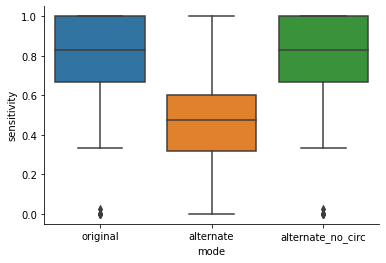

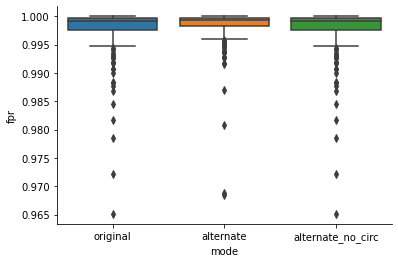

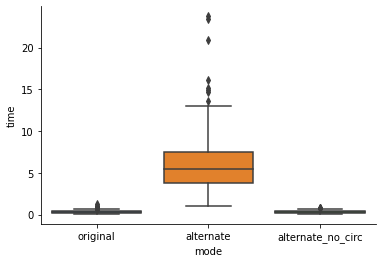

In [93]:
res = pd.DataFrame(res_)
res['sensitivity'] = res.TP / (res.TP + res.FN)
res['fpr'] = res.FP / (res.FP + res.TP)
res['mode'] = 'original'

res_alt = pd.DataFrame(res_alt_)
res_alt['sensitivity'] = res_alt.TP / (res_alt.TP + res_alt.FN)
res_alt['fpr'] = res_alt.FP / (res_alt.FP + res_alt.TP)
res_alt['mode'] = 'alternate'

results = pd.concat([res, res_alt])
results.to_csv('/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img/results')

import seaborn as sns
sns.boxplot(data=results, x='mode', y='sensitivity')
sns.despine()
plt.show()

sns.boxplot(data=results, x='mode', y='fpr')
sns.despine()
plt.show()

sns.boxplot(data=results, x='mode', y='time')
sns.despine()
plt.show()


In [94]:
14*14

196

In [62]:
# import time
# res = []
# def detection(db, idx):
#     rbd_path = '/home/jseia/Desktop/ml-dl/data/recounstructed_by_dialation_img'
#     md = MorphologyDetection(rbd_path, threshold=0.97, alternative=False, store_intermediate=False)
#     case = db[idx]
#     image = case['img']
#     image_id = db.df.iloc[idx].img_id
#     radiouses = case['radiuses']
#     true_bboxes = db[idx]['lesion_bboxes']
#     start = time.time()
#     _, candidate_blobs = md.detect(image, image_id)
#     t = time.time() - start
#     tp, fp, fn, _, _ = get_tp_fp_fn(true_bboxes, radiouses, candidate_blobs, 7, 0.1)
#     return {'img_id': image_id, 'TP': len(tp), 'FP': len(fp), 'FN': len(fn), 'time': t, 'size': image.size}

# from functools import partial 
# par_f = partial(detection, db=db)

# res = []
# with mp.Pool(6) as pool:
#     for result in tqdm(pool.imap(par_f, range(len(db))), total=len(db)):
#         res.append(result)